# Лабораторная работа №1. Градиентные методы оптимизации

In [76]:
from sklearn import datasets
from typing import Tuple, Mapping

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.animation as animation
import numpy as np
import math

from IPython.display import HTML

## Функция Швефеля
### x,y от -10 до 10
### глобальный экстремум 0
### точка глобального экстремума (0, 0)

In [28]:
def func_Shvefel(x: np.ndarray) -> np.float64:
    return x[0] * x[0] + (x[0] + x[1]) ** 2

def grad_Shvefel(x: np.ndarray) -> np.ndarray:
    return np.array([2 * x[0] + 2 * (x[0] + x[1]), 2 * (x[0] + x[1])])

<IPython.core.display.Javascript object>


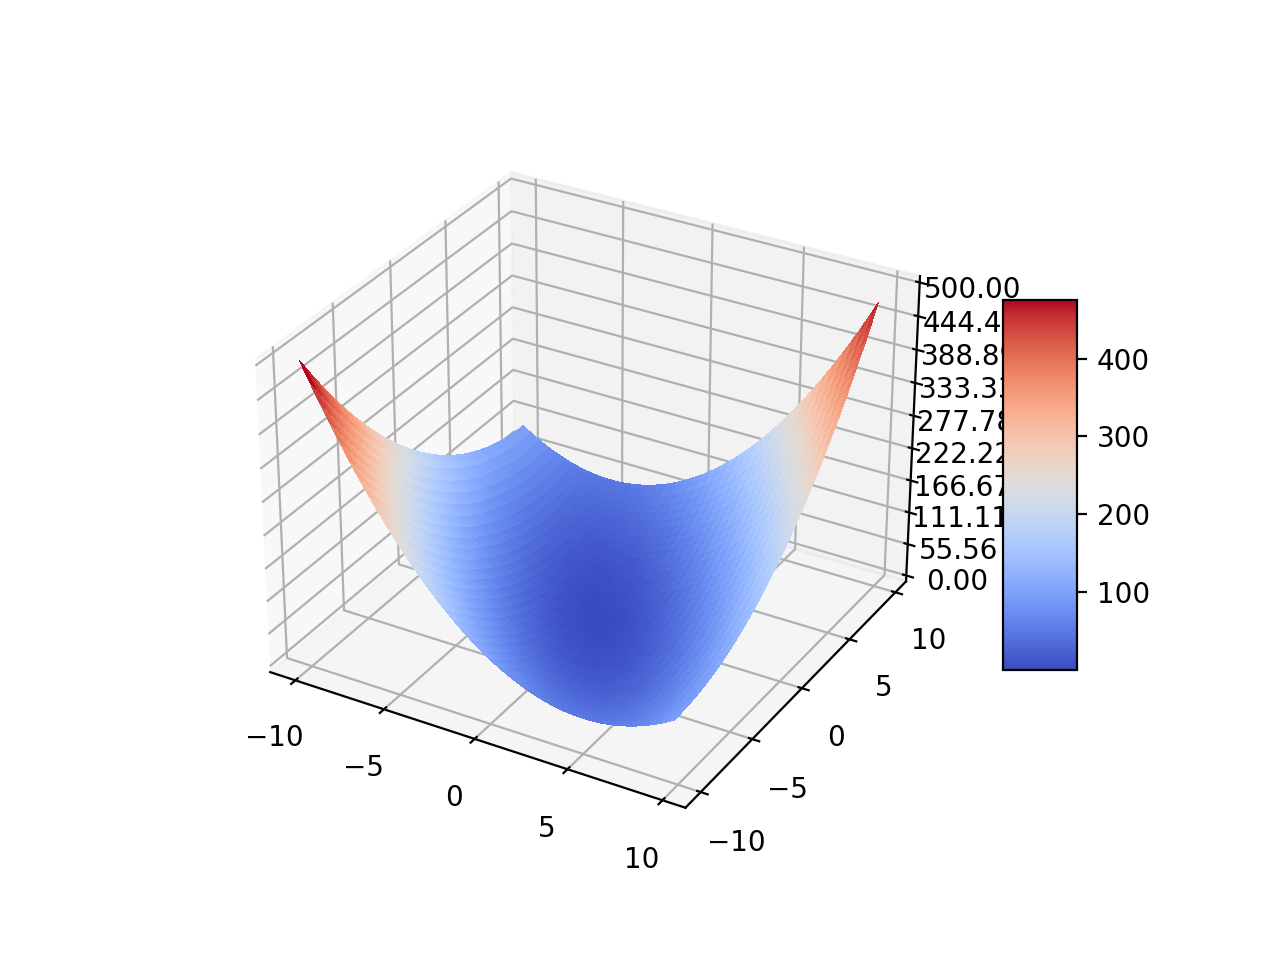

In [29]:
# Make data.
X = np.arange(-10, 10, 0.25)
Y = np.arange(-10, 10, 0.25)
X, Y = np.meshgrid(X, Y)
Z = func_Shvefel(np.array([X, Y]))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### Градиентный спуск

In [30]:
def my_GD(f: Mapping, df: Mapping, x0: np.ndarray, lr: float = 0.001, max_iter: int = 10000) -> tuple[np.ndarray, np.float32, np.ndarray]:
    x_old = x0.copy()
    history = [np.array([x_old[0], x_old[1], f(x_old)])]
    for i in range(max_iter):
        x_new = x_old - lr * df(x_old)
        x_old = x_new
        history.append(np.array([x_new[0], x_new[1], f(x_new)]))

    return x_new, f(x_new), np.array(history)

In [31]:
%matplotlib notebook

In [58]:
def plot_GD(f: Mapping, df: Mapping, x0: np.ndarray, lr: float = 0.001, max_iter: int = 10000, GD_type: Mapping = my_GD, video_name = "GD"):
    x1, z1, history = GD_type(f, df, x0, lr, max_iter)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    # Plot the surface.
    X = np.arange(-10, 10, 0.25)
    Y = np.arange(-10, 10, 0.25)
    X, Y = np.meshgrid(X, Y)
    Z = f(np.array([X, Y]))
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5)

    # Customize the z axis.
    #ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    #xx = ax.scatter(x0[0], x0[1], func_Shvefel(x0), c = 'black')
    
    line, = ax.plot([], [], [], 'r-', label = 'Gradient descent', lw = 1.5)
    point, = ax.plot([], [], [], '*', color = 'black')
    
    line.set_data([], [])
    line.set_3d_properties([])
    point.set_data([x0[0]], [x0[1]])
    point.set_3d_properties([func_Shvefel(x0)])
    
    def update_point(i):
        i = i + 1
        if (i == len(history)):
            return line, point
        #print(history[:2,0])
        #xx.set_data(history[i][0], history[i][1], history[i][2], c = 'black')
        # Animate line
        line.set_data(history[:i, 0], history[:i, 1])
        line.set_3d_properties(history[:i, 2])

        # Animate points
        point.set_data([history[i][0]], [history[i][1]])
        point.set_3d_properties([history[i][2]])
        return line, point
        
    ani = animation.FuncAnimation(fig, update_point, frames=range(len(history)),interval = 50, blit=True)
    
    writervideo = animation.FFMpegWriter(fps=60)
    ani.save(f'./media/{video_name}.mp4', writer=writervideo)
    return x1[0], x1[1], z1

In [59]:
my_GD(func_Shvefel, grad_Shvefel, np.array([10, 10]), max_iter = 5000)

(array([-0.03741523,  0.06053912]),
 0.0019346137822891848,
 array([[ 1.00000000e+01,  1.00000000e+01,  5.00000000e+02],
        [ 9.94000000e+00,  9.96000000e+00,  4.94813600e+02],
        [ 9.88032000e+00,  9.92020000e+00,  4.89681316e+02],
        ...,
        [-3.74724642e-02,  6.06317209e-02,  1.94053674e-03],
        [-3.74438378e-02,  6.05854024e-02,  1.93757300e-03],
        [-3.74152333e-02,  6.05391192e-02,  1.93461378e-03]]))

<IPython.core.display.Javascript object>


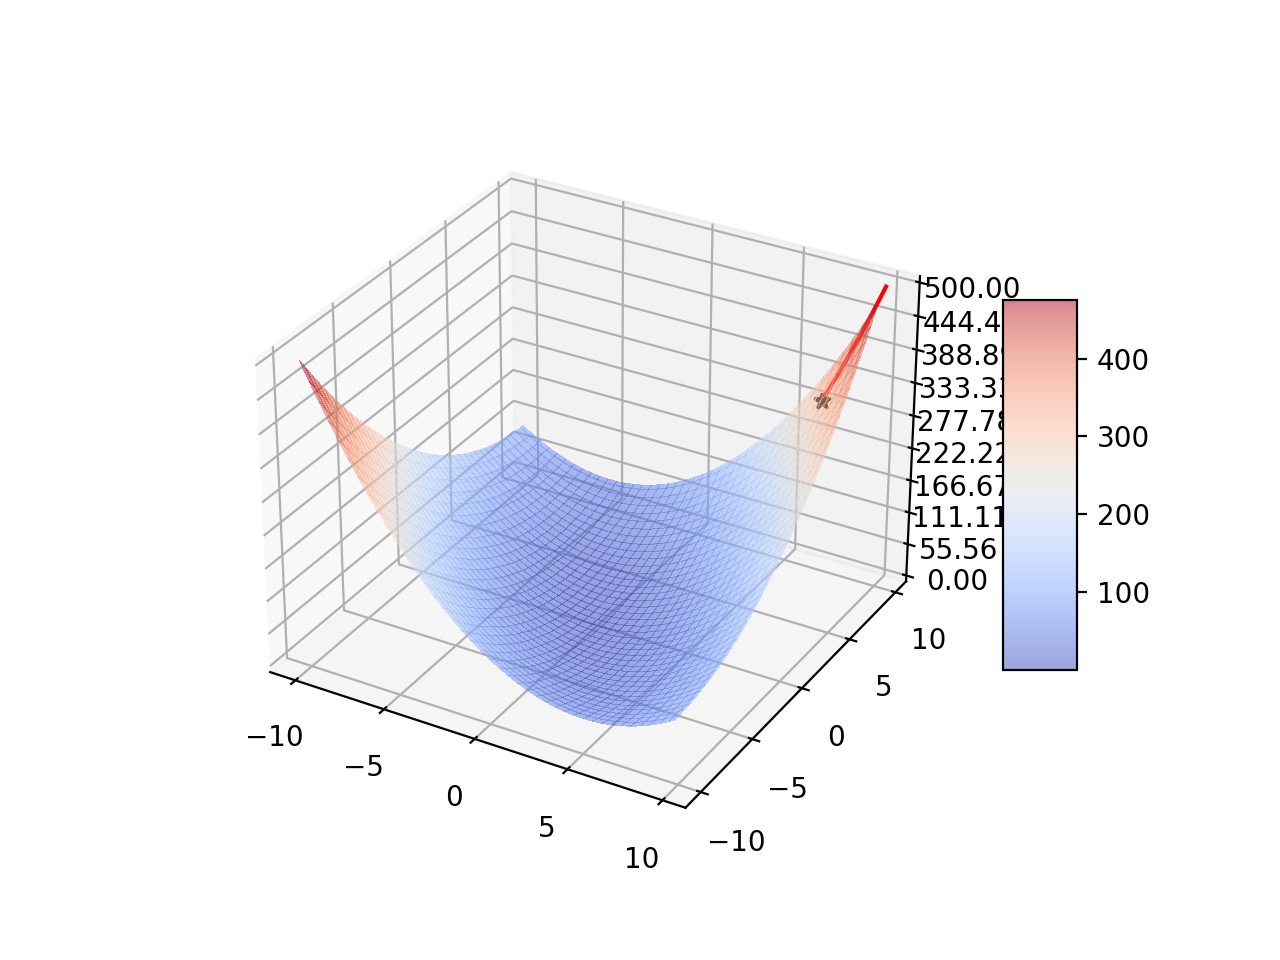

(-0.03741523326662676, 0.06053911922667013, 0.0019346137822891848)

In [60]:
plot_GD(func_Shvefel, grad_Shvefel, np.array([10, 10]), max_iter = 5000)

### Метод импульсов

In [39]:
def impulse_method(f: Mapping, df: Mapping, x0: np.ndarray, lr: float = 0.001, max_iter: int = 10000, gamma: float = 0.9) -> tuple[np.ndarray, np.float32, np.ndarray]:
    if (gamma > 1 or gamma < 0):
        print('incorrect gamma. Set default gamma = 0.9')
        gamma = 0.9
    
    x_old = x0.copy()
    u = 0
    history = [np.array([x_old[0], x_old[1], f(x_old)])]
    for i in range(max_iter):
        u = gamma * u + lr * df(x_old)
        x_new = x_old - u
        x_old = x_new
        history.append(np.array([x_new[0], x_new[1], f(x_new)]))

    return x_new, f(x_new), np.array(history)

In [67]:
impulse_method(func_Shvefel, grad_Shvefel, np.array([10, 10]), gamma = 0.6, max_iter = 5000)

(array([-0.00011768,  0.00019041]),
 1.913751707454568e-08,
 array([[ 1.00000000e+01,  1.00000000e+01,  5.00000000e+02],
        [ 9.94000000e+00,  9.96000000e+00,  4.94813600e+02],
        [ 9.84432000e+00,  9.89620000e+00,  4.86598766e+02],
        ...,
        [-1.18129769e-04,  1.91137982e-04,  1.92848415e-08],
        [-1.17903510e-04,  1.90771887e-04,  1.92110381e-08],
        [-1.17677685e-04,  1.90406493e-04,  1.91375171e-08]]))

<IPython.core.display.Javascript object>


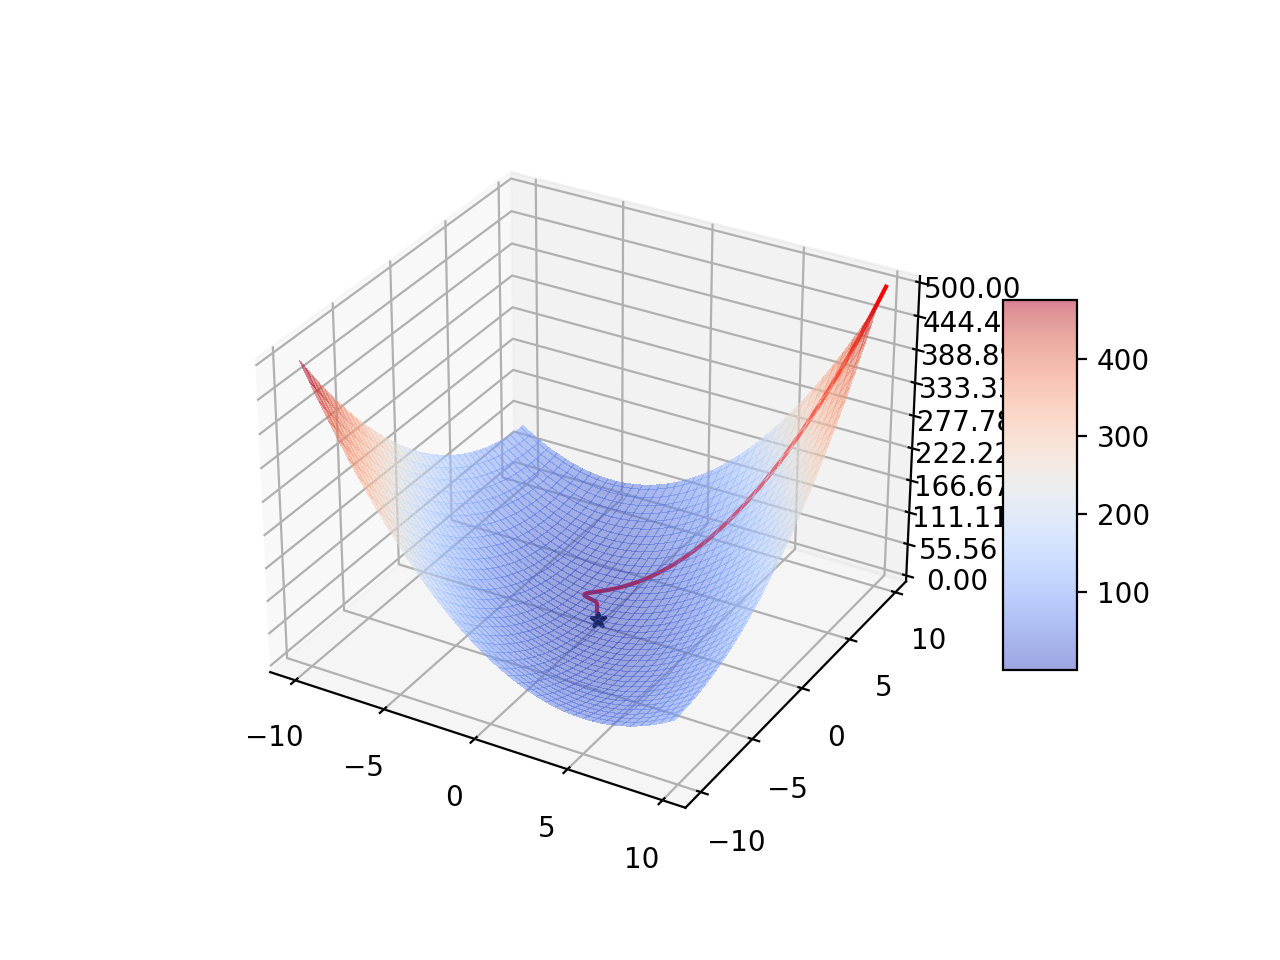

(-1.8016528940104995e-36, 2.915135618438599e-36, 4.485796928096231e-72)

In [68]:
plot_GD(func_Shvefel, grad_Shvefel, np.array([10, 10]), GD_type = impulse_method, video_name = "impulse_GD")

### Adam

In [70]:
def Adam(f: Mapping, df: Mapping, x0: np.ndarray, lr: float = 0.001, max_iter: int = 10000, beta1: float = 0.9, beta2: float = 0.999, eps: float = 10e-8) -> tuple[np.ndarray, np.float32, np.ndarray]:
    if (beta1 > 1 or beta1 < 0):
        print('incorrect beta1. Set default beta1 = 0.9')
        beta1 = 0.9
    
    if (beta2 > 1 or beta2 < 0):
        print('incorrect beta2. Set default beta1 = 0.999')
        beta2 = 0.999
    
    x_old = x0.copy()
    u = 0
    m = 0
    v = 0
    
    history = [np.array([x_old[0], x_old[1], f(x_old)])]
    for i in range(max_iter):
        m = beta1 * m + (1 - beta1) * df(x_old)
        v = beta2 * v + (1 - beta2) * df(x_old)
        u = lr * m / (np.sqrt(v) + eps)
        x_new = x_old - u
        x_old = x_new
        history.append(np.array([x_new[0], x_new[1], f(x_new)]))

    return x_new, f(x_new), np.array(history)

In [74]:
Adam(func_Shvefel, grad_Shvefel, np.array([10, 10]), max_iter = 5000)

(array([-0.07386122,  0.12606531]),
 0.008180746948654147,
 array([[ 1.00000000e+01,  1.00000000e+01,  5.00000000e+02],
        [ 9.97550511e+00,  9.98000001e+00,  4.97732887e+02],
        [ 9.94260884e+00,  9.95313976e+00,  4.94696283e+02],
        ...,
        [-7.40385488e-02,  1.26360606e-01,  8.21930439e-03],
        [-7.39498520e-02,  1.26212904e-01,  8.20000724e-03],
        [-7.38612239e-02,  1.26065310e-01,  8.18074695e-03]]))

<IPython.core.display.Javascript object>


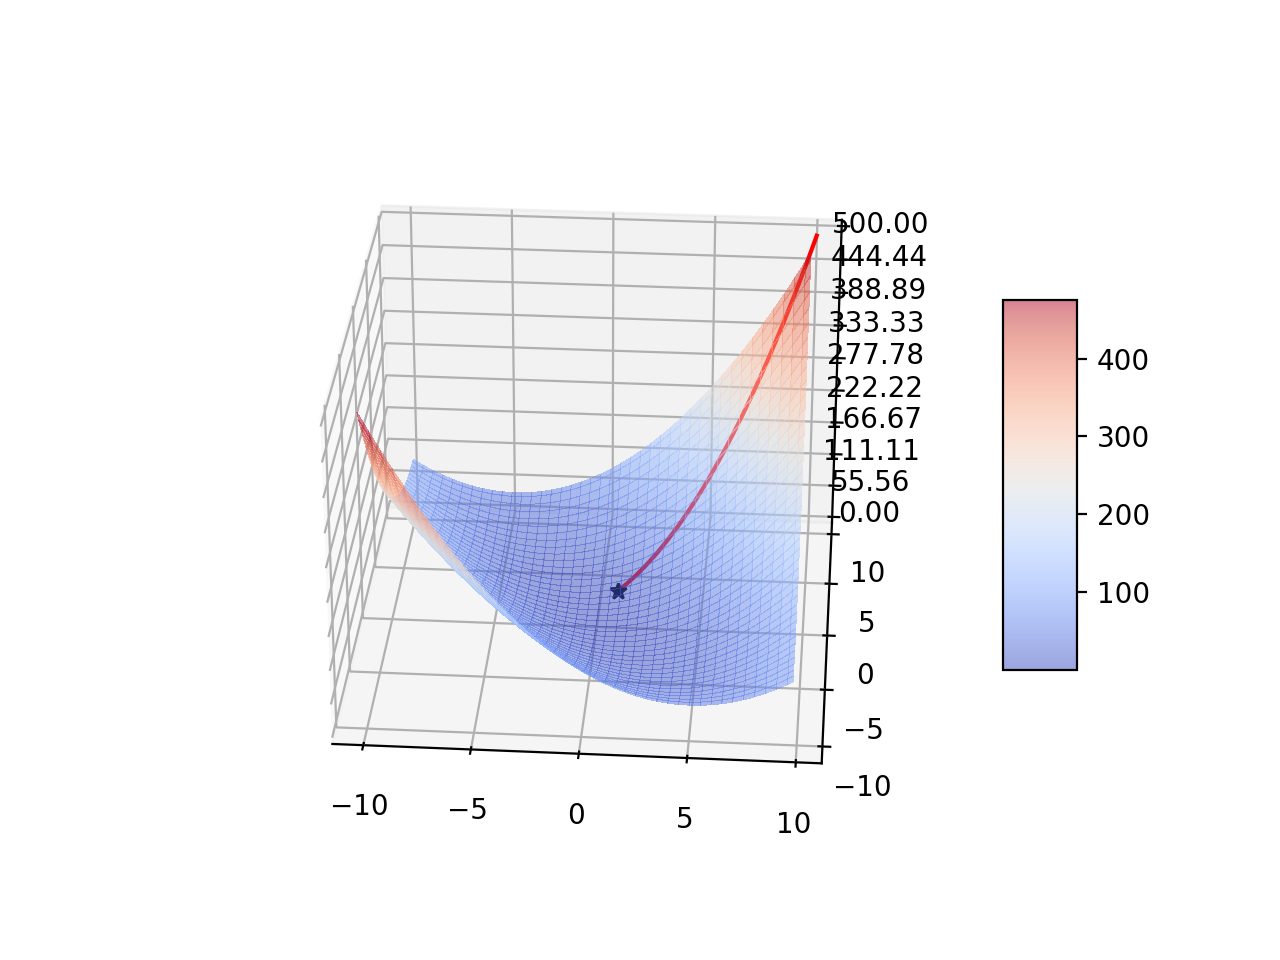

(-0.0738612238837574, 0.12606530950018796, 0.008180746948654147)

In [75]:
plot_GD(func_Shvefel, grad_Shvefel, np.array([10, 10]), max_iter = 5000, GD_type = Adam, video_name = "Adam")

### Learning rate scheduler

In [85]:
def lr_scheduler(f: Mapping, df: Mapping, x0: np.ndarray, type: str, lr: float = 0.01, max_iter: int = 10000) -> tuple[np.ndarray, np.float32, np.ndarray]:
    '''
    type can be:
    - linear
    - exponential
    '''
    
    if type not in ('linear', 'exponential'):
        print("incorrect type")
        return

    x_old = x0.copy()
    history = [np.array([x_old[0], x_old[1], f(x_old)])]
    for i in range(max_iter):
        if type == "linear":
            lr = lr * (1 - float(i) / max_iter)
        else:
            lr = lr * math.exp(-float(i) / max_iter)
        x_new = x_old - lr * df(x_old)
        x_old = x_new
        history.append(np.array([x_new[0], x_new[1], f(x_new)]))

    return x_new, f(x_new), np.array(history)

In [88]:
lr_scheduler(func_Shvefel, grad_Shvefel, np.array([10, 10]), type = "linear", max_iter = 5000)

(array([-0.76329567,  1.4705093 ]),
 1.0827714050262436,
 array([[ 10.        ,  10.        , 500.        ],
        [  9.4       ,   9.6       , 449.36      ],
        [  8.8321136 ,   9.220076  , 403.88778   ],
        ...,
        [ -0.76329567,   1.4705093 ,   1.08277141],
        [ -0.76329567,   1.4705093 ,   1.08277141],
        [ -0.76329567,   1.4705093 ,   1.08277141]]))